**STATISTICAL LEARNING AND NEURAL NETWORKS, A.A. 2022/2023**

**COMPUTER LAB 4** - Kalman filter

**Duration: 3 hours**

**Introduction:**

In this lab, you are provided with the set of coordinates (x,y – horizontal and vertical) describing the trajectories of pedestrians moving acrooss a scene. Your task is to simulate the observed positions of the pedestrians by adding observation noise, then to track the subjects using a Kalman filter. In other words, you need to estimate the next (x,y) positions, from the observations of the previous positions.


*Simulating the observed coordinates*

Choose one of the trajectories in the dataset. This data will be considered the real trajectory. Generate the observed directions by adding observation noise $\delta_t \sim\ \mathcal{N}(0,\sigma^{2}_{R})$ to the (x,y) coordinates.


*Designing the Kalman filter*

Your task is to **design a Kalman filter** based on a constant velocity model, which tracks the next (x,y) position of the object, from the observation of the previous positions. The code must be based on the following model.

*   The state vector contains coordinates and velocities: $z^{T}_{t} = (z_{1t}, z_{2t}, v_{1t}, v_{2t})$ (see slides). The object has initial coordinates (0,0) and velocity $(\Delta,Δ)$.
*   Only the coordinates (but not the velocities) are observed. This leads to a linear dynamical system with:

$A = \left( \begin{matrix} 1 & 0 & \Delta & 0 \\ 0 & 1 & 0 & \Delta \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$


$C = \left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{matrix} \right)$

and B = D = 0.

*   $\Sigma_{Q}$, and $\Sigma_{R}$ should be set to:

$\Sigma_{Q} = \sigma^{2}_{Q}\left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$

$\Sigma_{R} = \sigma^{2}_{R}\left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$

To see if your Kalman filter is working well, you should plot the estimated position of the object over time with respect to the true position (i.e., the first two entries of the state vector) and the observed position. Depending on the chosen parameters, for each coordinate the graph may look something like this:

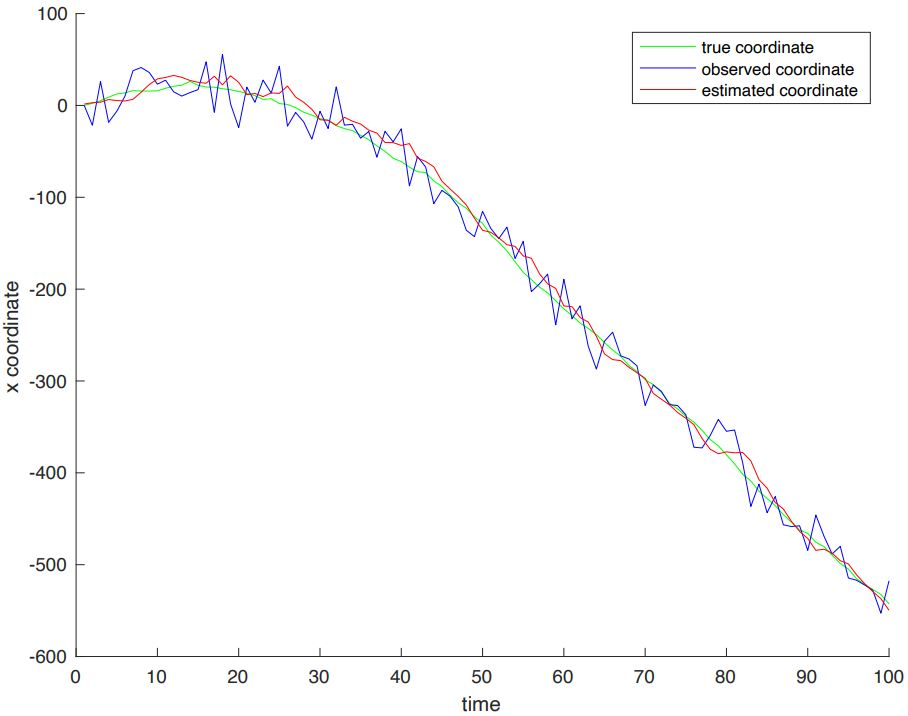

**Suggestion**: when implementing your Kalman filter, you will have to choose initial values for **$\mu_{t}$** and **$\Sigma_{t}$**. Provided that you do not make very unreasonable assumptions, the Kalman filter will update those estimates from observed data, so the initial choices are not very critical. 

Test your Kalman filter modifying the values of some of the parameters, including standard deviations **$\sigma_{Q}$** and **$\sigma_{R}$**, initial values for **$\mu_{t}$** and **$\Sigma_{t}$** and the value of **$\Delta$**.

In [1]:
import ndjson
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
#Dataset origin: https://paperswithcode.com/dataset/trajnet-1
#The crowds_students001 file is loaded, and formatted as a list of numpy vectors

with open('./crowds_students001_trackonly.ndjson') as f:
    data = ndjson.load(f)

p = '-1'

person_dict = []

for ii in range(len(data)):
    if p != data[ii]['track']['p']:
        p = data[ii]['track']['p']
        person_dict.append([])
    person_dict[p].append((data[ii]['track']['x'], data[ii]['track']['y']))

person_dict_numpy = []
for ii in range(148):
    person_dict_numpy.append(np.array(person_dict[ii], dtype=float))

The dataset $data$ format is the following:
    - $f$: frame (multiplies of $10$)
    - $p$: pedestrian index
    - $x$: $x$ coordinate
    - $y$: $y$ coordinate
$person\_dict$ and $person\_dict\_numpy$ contain each track portion for each pedestrian

In [13]:
# Implement the kalman filter as a function using the numpy library, the matrix products can be done using the np.dot function
# The matrix inversion can be done using the np.linalg.inv
def kalman_filter(y, mu_tmin1, sigma_tmin1, A, C, Q, R):
    # Prediction step
    mu_next = A @ mu_tmin1
    sigma_next = A @ sigma_tmin1 @ A.T + Q
    y_est = C @ mu_next
    # Computing the Kalman gain
    K = sigma_next @ C.T @ np.linalg.inv(C @ sigma_next @ C.T + R)
    r = y - y_est
    # Update step
    mu_est = mu_next + K @ r
    sigma_est = (np.eye(4) - K @ C) @ sigma_next
    return mu_est, sigma_est

In [61]:
traj_index = 28
#choose a single trajectory by taking an element of the list person_dict_numpy, select a random index between 0 and 148
current_index = np.random.randint(len(person_dict_numpy)) if traj_index == -1 else traj_index
print(f'Current trajectory index: {current_index}')
true_positions = person_dict_numpy[current_index]
N = true_positions.shape[0]

#Define parameter delta
# TODO tweak
Delta = 1
A = np.array([[1, 0, Delta, 0],
              [0, 1, 0, Delta],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

# Define the measurement matrix
C = np.array([[1, 0, 0, 0],  # x is measured directly
              [0, 1, 0, 0]])  # y is measured directly

# Set the standard deviation of the measurement noise
# TODO tweak
sigma_R = 0.5
sigma_Q = 0.1

# Define the process noise covariance matrix
Q = (sigma_Q ** 2) * np.eye(4)

# Define the measurement noise covariance matrix
R = (sigma_R ** 2) * np.eye(2)

# Set the initial state and covariance
# TODO tweak
mu_0 = np.array([0, 0, 1, 1])
sigma_0 = sigma_Q * np.ones(4)

# Iterate over the observed coordinates
obs_positions = np.empty(shape=(N, 2))
obs_positions[0] = true_positions[0] + np.random.normal(0, sigma_R, 2)
est_positions = np.empty(shape=(N, 2))
est_positions[0] = mu_0[:2]
for t in range(1, len(true_positions)):
    # Get the observed coordinates at time t 
    # Note: the observed position is simulated by adding gaussian noise to the true_positions
    y = true_positions[t] + np.random.normal(0, sigma_R, 2)
    obs_positions[t] = y

    #apply the kalman filter on the observed coordinates
    mu_0, sigma_0 = kalman_filter(y, mu_0, sigma_0, A, C, Q, R)
    est_positions[t] = mu_0[:2]

Current trajectory index: 28


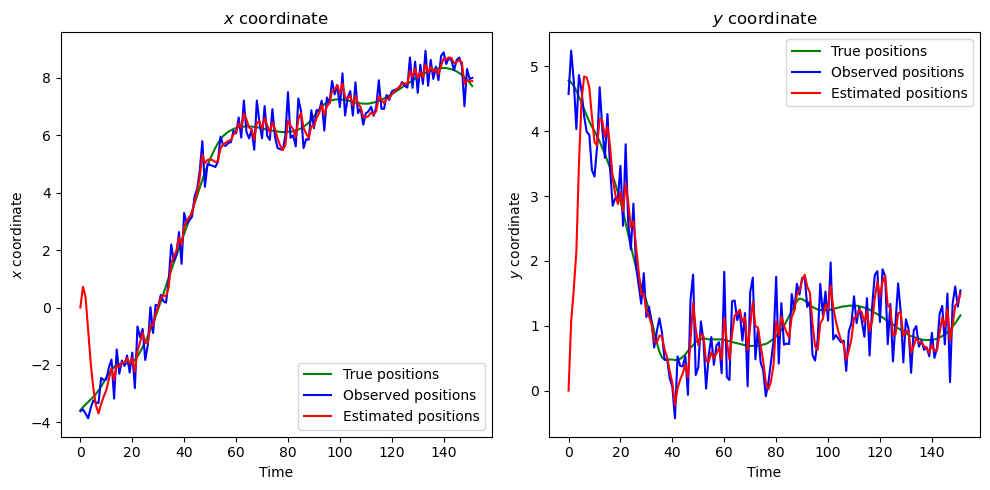

In [62]:
#Use the matplotlib library to plot the true positions, observed positions y and the results of the kalman filtering
#You should obtain a plot which resembles the one in the figure 
#Plot the trajectory of the x coordinate over time and the trajectory of the y coordinate over time into two separate plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(true_positions[:, 0], 'g')
plt.plot(obs_positions[:, 0], 'b')
plt.plot(est_positions[:, 0], 'r')
plt.xlabel('Time')
plt.ylabel('$x$ coordinate')
labels = ['True positions', 'Observed positions', 'Estimated positions']
plt.legend(labels)
plt.title('$x$ coordinate')
plt.subplot(1, 2, 2)
plt.plot(true_positions[:, 1], 'g')
plt.plot(obs_positions[:, 1], 'b')
plt.plot(est_positions[:, 1], 'r')
plt.xlabel('Time')
plt.ylabel('$y$ coordinate')
labels = ['True positions', 'Observed positions', 'Estimated positions']
plt.legend(labels)
plt.title('$y$ coordinate')
plt.tight_layout()
plt.show()